Basics

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt
#clustering
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
from qtensor import get_edge_subgraph
import torch

2021-07-12 07:09:05,488- WARNING•	QuickBB solver is unavailable
2021-07-12 07:09:05,490- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


# Importing graphs

In [4]:
g_data = []
with open('20NodeRandomData1.csv', 'r', newline = '') as s:
  spamreader = csv.reader(s, quotechar='|')
  for row in spamreader:
    new_row = [float(i) for i in row]
    g_data.append(new_row)

In [5]:
resi = []
with open('20NodeRandomGraph1.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    resi.append(row)

#convert bunch of rows to matrices
n = int(len(resi)/20)
mat_list = []
for i in range(n):
  array = []
  for j in range(20):
    row = resi[i*20 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

In [6]:
def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

In [7]:
g_list = mats_to_graphs(mat_list)

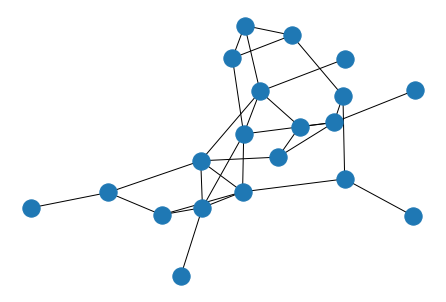

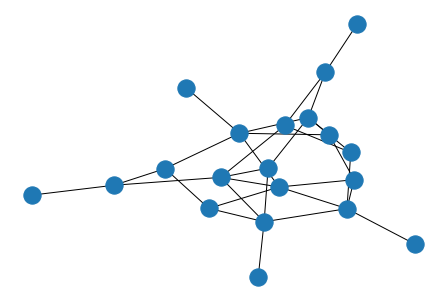

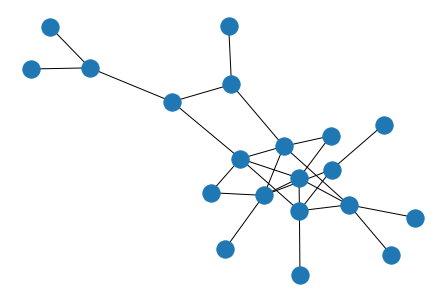

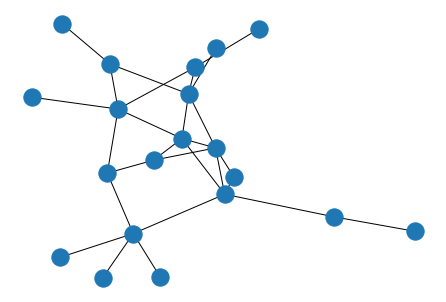

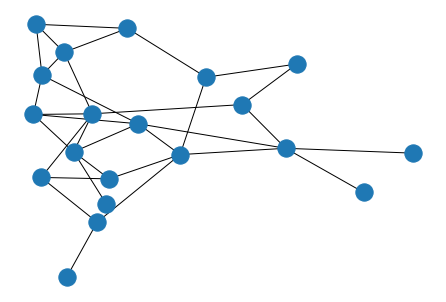

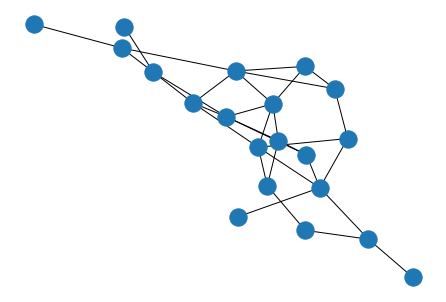

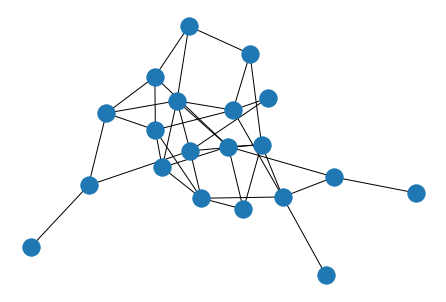

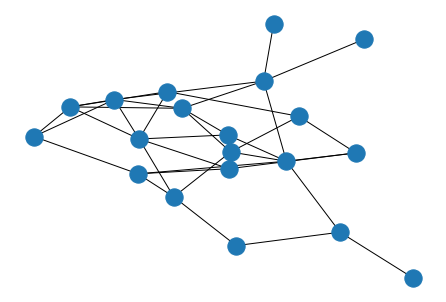

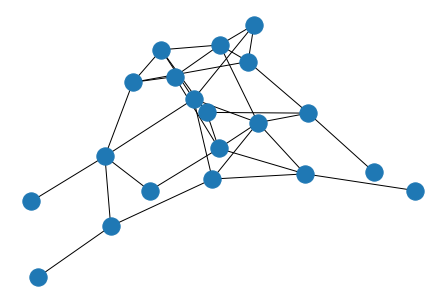

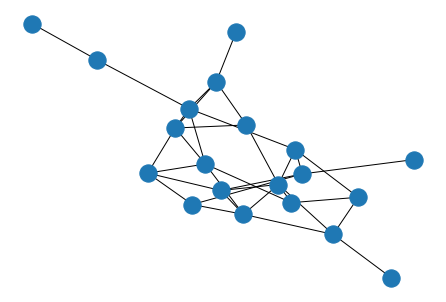

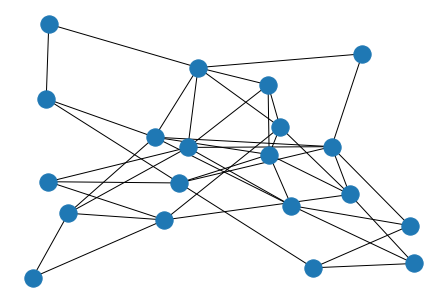

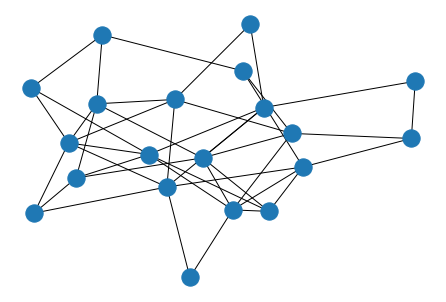

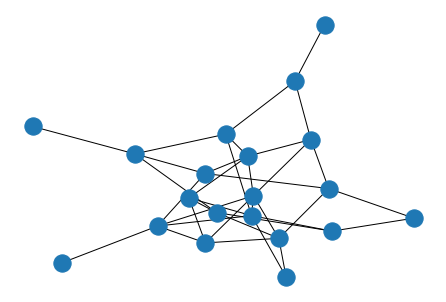

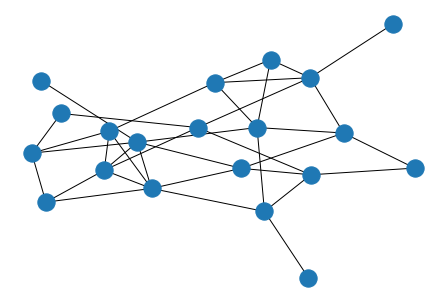

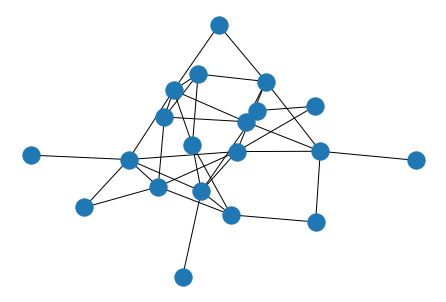

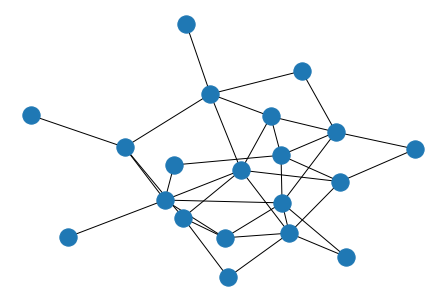

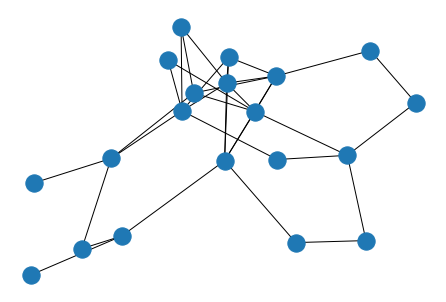

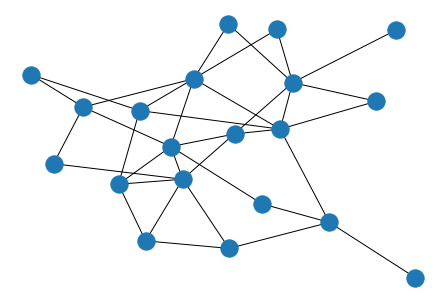

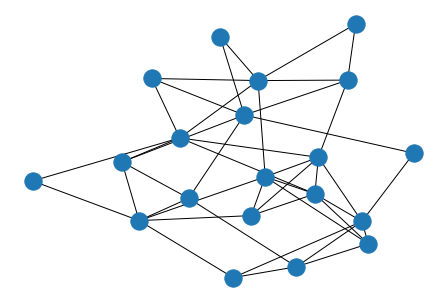

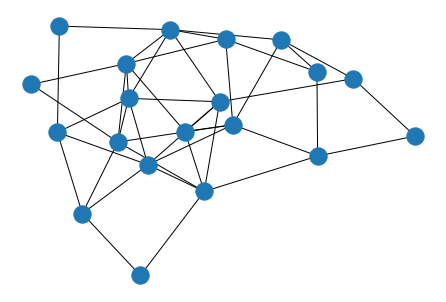

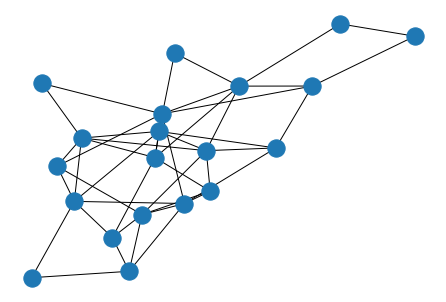

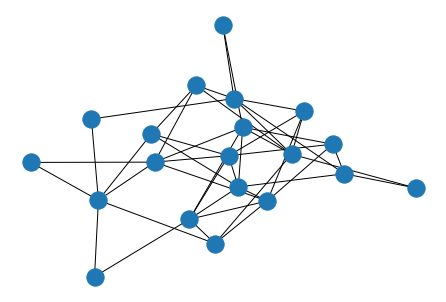

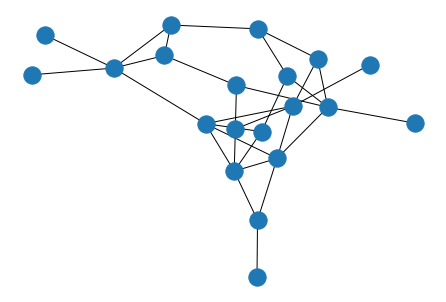

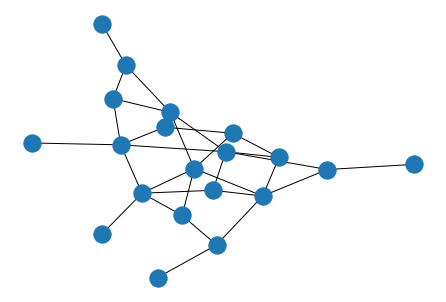

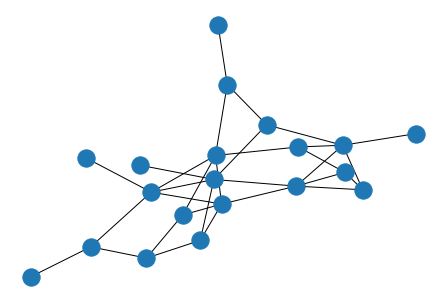

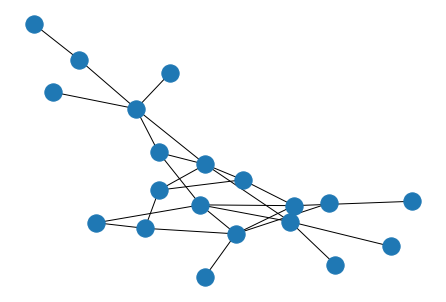

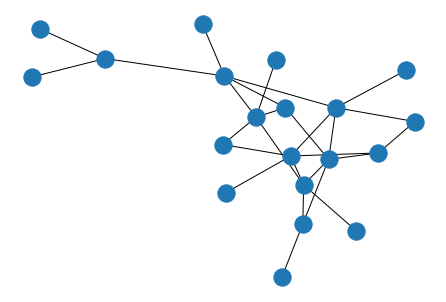

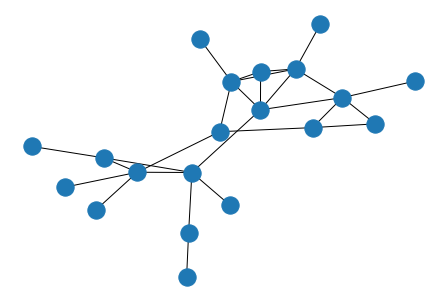

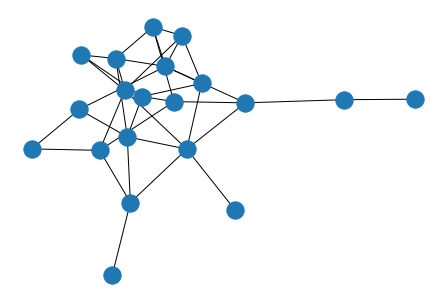

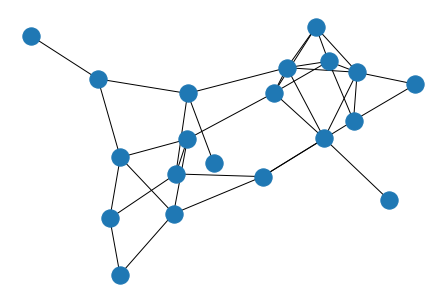

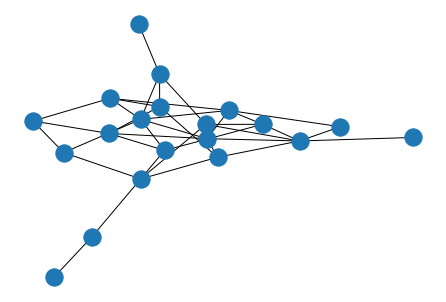

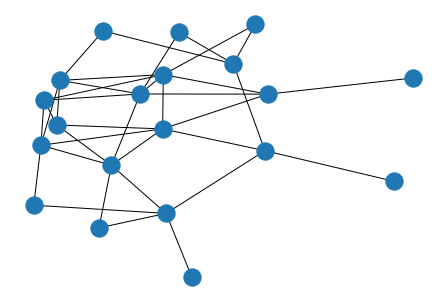

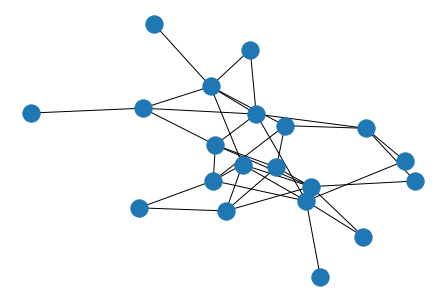

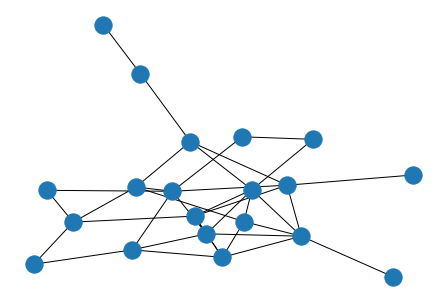

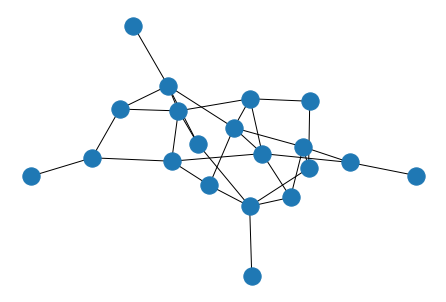

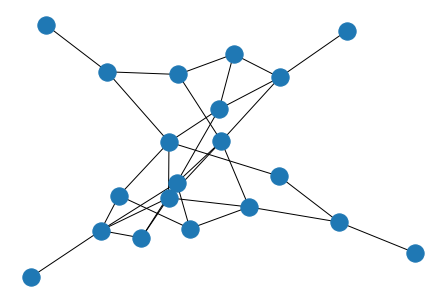

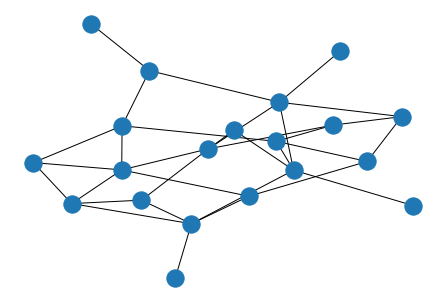

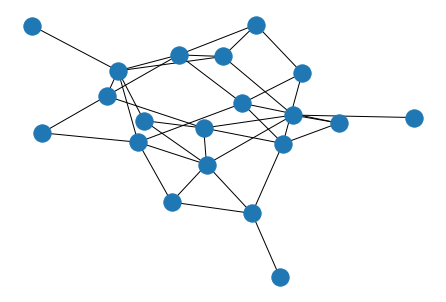

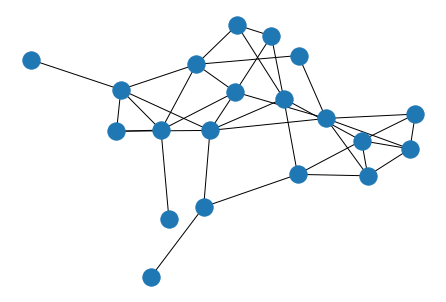

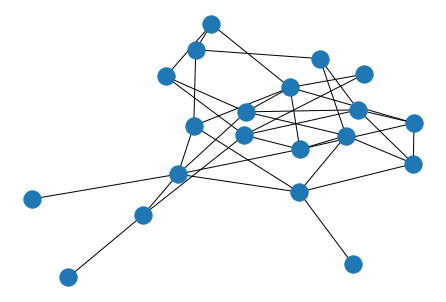

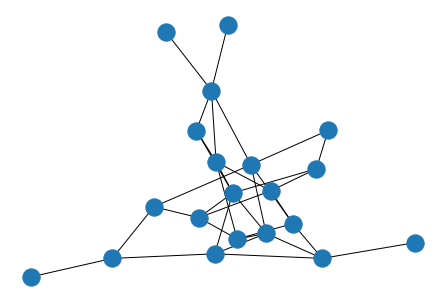

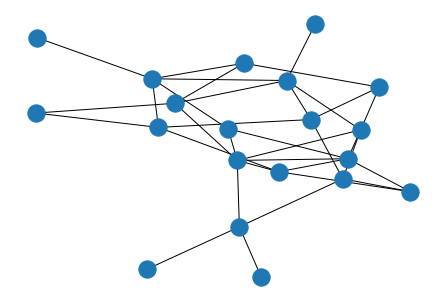

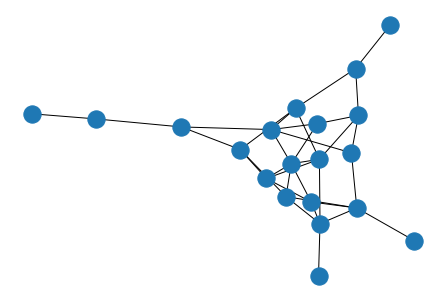

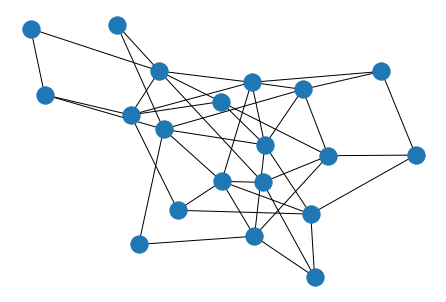

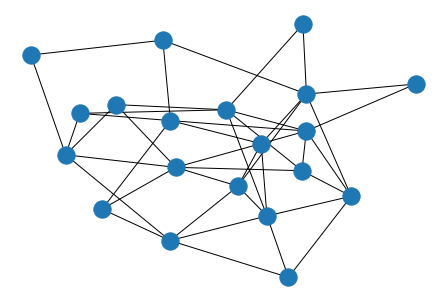

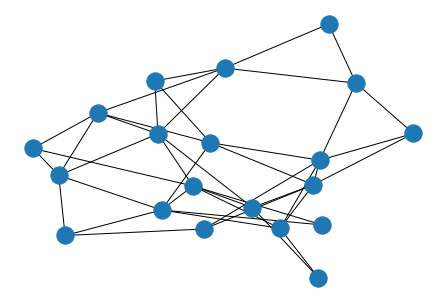

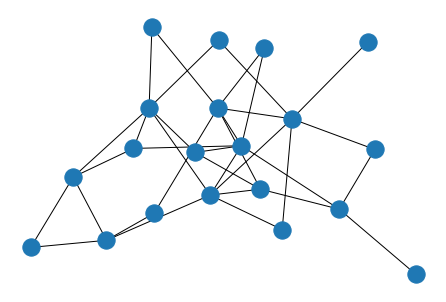

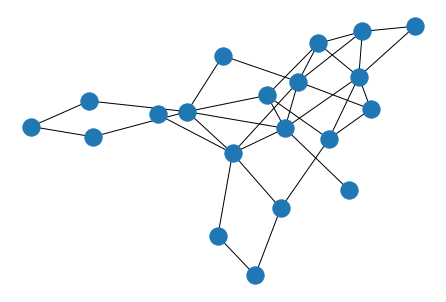

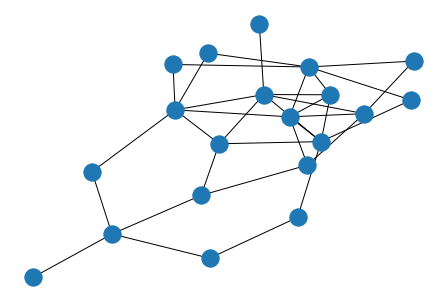

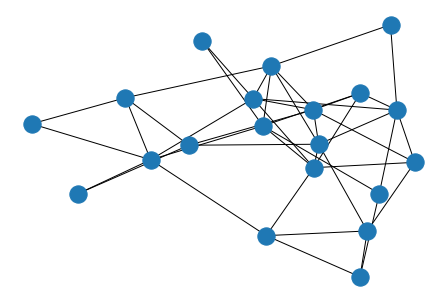

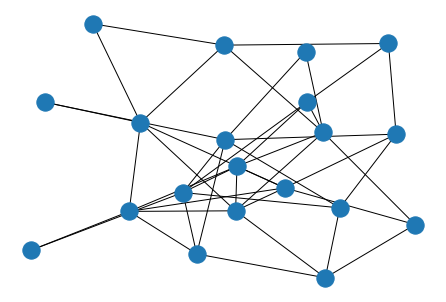

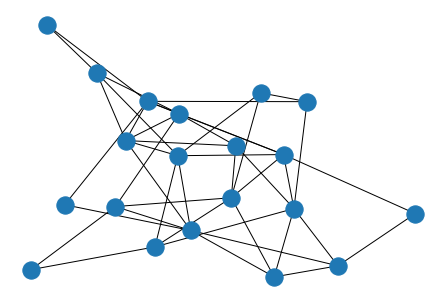

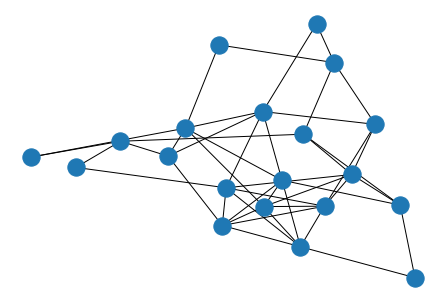

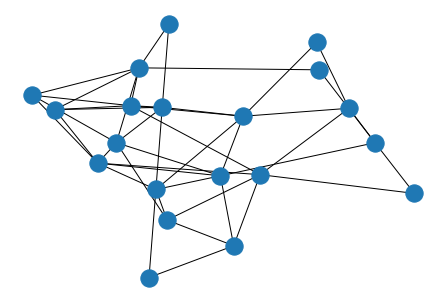

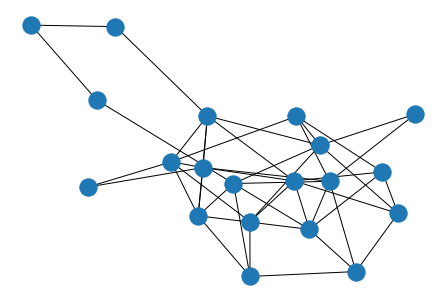

In [8]:
for i in g_list:
  nx.draw(i)
  plt.show()

# Generating library of p=2 subgraphs

In [42]:
def is_isomorphic(graph, graphs):
    """
    Checks if a graph is isomorphic with any graph in the list graphs
    """
    if len(graphs) ==0:
        return False
    
    for g in graphs:
        if nx.is_isomorphic(graph, g):
            return True
    return False

In [74]:
master = {} #dictionary with keys as subgraphs and values as central edges
iterr = 0
for G in g_list[0:2]:
    iterr+=1
    print(iterr)
    for edge in G.edges:
        sub = get_edge_subgraph(G, edge = edge, dist = 2)
        if not is_isomorphic(sub, master.keys()):
            master[sub] = edge
            

1
2


In [75]:
len(master)

61

# Now finding its local optima

In [76]:
def fix_gamma(params):
    """
    Assuming gamma ranges from 0 to 1 
    """
    new_params = []
    for p in params:
        gamma = p
        gamma = gamma%1
        new_params.append(gamma)
    return new_params

def fix_beta(params):
    """
    Assuming beta ranges from 0 to 0.5 
    """
    new_params = []
    for p in params:
        beta = p
        beta = beta%0.5
        new_params.append(beta)
    return new_params

In [77]:
def get_local_optima(subgraph,cutoff = 0.001, edge=(0,1), p=2,steps=200, multistarts =50):
    """
    Given a subgraph return those witin 10% of global
    """
    all_params = []
    all_energies = []
    print(edge)
    for m in range(multistarts):
        print(m)
        
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        loss_history, params_history = popt.qaoa_maxcut_torch(subgraph, gamma, beta,
                                                              ordering_algo='greedy',
                                                              Opt=torch.optim.RMSprop,
                                                              edge=edge,
                                                              opt_kwargs=dict(lr=0.002),
                                                              steps=steps,
                                                              pbar=False)
        energies_history = [(1-loss)/2 for loss in loss_history]
        
        all_params+=params_history
        all_energies+=energies_history
    
    #print(all_energies)
    best_index = np.argmax(all_energies)
    best_energy = float(all_energies[best_index])
    best_param = all_params[best_index]
    
    #storing data for local optima
    local_params= [best_param]
    local_energies = [best_energy]
    
    #add all local
    for i in range(len(all_energies)):
        energy = all_energies[i]
        params = all_params[i]
        
        if (abs(energy-best_energy)/best_energy)<cutoff:
            local_params.append(params)
            local_energies.append(energy)
    
        
    return local_params, local_energies


In [78]:
gamma1s = []
gamma2s = []
beta1s=[]
beta2s = []
num_locals = []
energies = []

iterr = 0
for sub in master.keys():
    print('#######################')
    iterr+=1
    print(iterr)
#     if (iterr>5):
#         break
    edge = master[sub]
    print(edge)
    par, en = get_local_optima(subgraph = sub,cutoff = 0.001, edge=edge, p=2,steps=200, multistarts =50)
    gamma1 = [float(par[i][0][0]) for i in range(len(par))]
    beta1 = [float(par[i][1][0]) for i in range(len(par))]
    gamma2 = [float(par[i][0][1]) for i in range(len(par))]
    beta2 = [float(par[i][1][1]) for i in range(len(par))]
    
    gamma1 = fix_gamma(gamma1)
    beta1 = fix_beta(beta1)
    gamma2 = fix_gamma(gamma2)
    beta2 = fix_beta(beta2)
    
    gamma1s+= gamma1
    gamma2s+= gamma2
    beta1s += beta1
    beta2s += beta2
    
    num_locals.append(len(en))
    energies.append(en)
    print(len(en))
    

#######################
1
(0, 2)
(0, 2)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2841
#######################
2
(0, 7)
(0, 7)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2911
#######################
3
(0, 14)
(0, 14)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
1930
#######################
4
(0, 15)
(0, 15)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
3027
#######################
5
(0, 17)
(0, 17)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2211
#######################
6
(1, 2)
(1, 2)
0
1
2
3
4
5
6
7
8
9
10
11
12


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
1184
#######################
44
(5, 15)
(5, 15)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
5861
#######################
45
(6, 7)
(6, 7)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2699
#######################
46
(6, 16)
(6, 16)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
3489
#######################
47
(6, 19)
(6, 19)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2482
#######################
48
(7, 8)
(7, 8)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
2

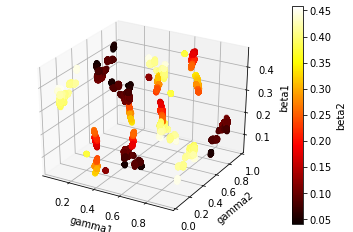

In [79]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = gamma1s
y = gamma2s
z = beta1s
c = beta2s

ax.set_xlabel('gamma1')
ax.set_ylabel('gamma2')
ax.set_zlabel('beta1')

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
cbar = fig.colorbar(img)
cbar.ax.set_ylabel("beta2")
plt.show()

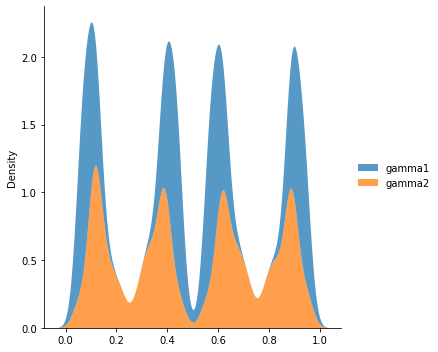

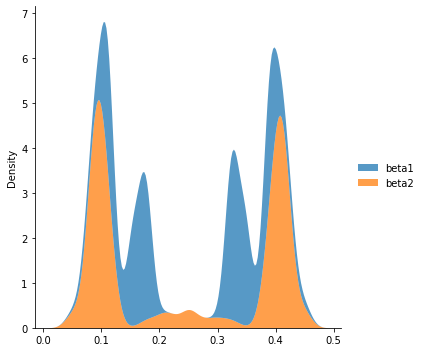

In [80]:
df_gamma = pd.DataFrame({'gamma1': gamma1s, 'gamma2':gamma2s})
df_beta = pd.DataFrame({'beta1': beta1s, 'beta2':beta2s})

sns.displot(df_gamma,kind="kde", multiple="stack", linewidth = 0)
plt.show()
sns.displot(df_beta,kind="kde", multiple="stack", linewidth = 0)
plt.show()

# Data

In [81]:
gamma1s

[0.4266713857650757,
 0.5711236596107483,
 0.571663498878479,
 0.5720841288566589,
 0.5724040865898132,
 0.5726437568664551,
 0.5728214383125305,
 0.572952389717102,
 0.57304847240448,
 0.5731188058853149,
 0.5731702446937561,
 0.5732077956199646,
 0.5732352137565613,
 0.5732552409172058,
 0.5732698440551758,
 0.5732805132865906,
 0.5732882618904114,
 0.573293924331665,
 0.5732980370521545,
 0.5733010768890381,
 0.57330322265625,
 0.5733048319816589,
 0.5733059644699097,
 0.5733067989349365,
 0.5733073949813843,
 0.5733078122138977,
 0.5733081102371216,
 0.5733083486557007,
 0.573308527469635,
 0.5733086466789246,
 0.5733087062835693,
 0.5733087658882141,
 0.5733088254928589,
 0.5733088254928589,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,
 0.5733088850975037,


In [82]:
gamma2s

[0.8730747103691101,
 0.6231576204299927,
 0.6242853403091431,
 0.6250647902488708,
 0.625605046749115,
 0.6259817481040955,
 0.6262463927268982,
 0.6264336705207825,
 0.6265671253204346,
 0.6266627311706543,
 0.6267315745353699,
 0.6267812848091125,
 0.6268172860145569,
 0.6268434524536133,
 0.6268624663352966,
 0.6268762350082397,
 0.626886248588562,
 0.6268935203552246,
 0.6268988251686096,
 0.6269026398658752,
 0.6269054412841797,
 0.626907467842102,
 0.6269089579582214,
 0.6269100308418274,
 0.6269108057022095,
 0.6269113421440125,
 0.6269117593765259,
 0.6269120573997498,
 0.6269122362136841,
 0.6269123554229736,
 0.6269124746322632,
 0.626912534236908,
 0.6269125938415527,
 0.6269126534461975,
 0.6269126534461975,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.6269127130508423,
 0.62691271305084

In [83]:
beta1s

[0.3505938649177551,
 0.146581768989563,
 0.1476764678955078,
 0.14837801456451416,
 0.14881587028503418,
 0.14908236265182495,
 0.14924049377441406,
 0.14933156967163086,
 0.14938199520111084,
 0.1494084596633911,
 0.14942115545272827,
 0.1494261622428894,
 0.14942717552185059,
 0.14942622184753418,
 0.1494244933128357,
 0.14942258596420288,
 0.14942079782485962,
 0.14941924810409546,
 0.1494179368019104,
 0.14941692352294922,
 0.14941608905792236,
 0.1494154930114746,
 0.1494150161743164,
 0.14941465854644775,
 0.14941442012786865,
 0.14941424131393433,
 0.14941412210464478,
 0.14941400289535522,
 0.14941394329071045,
 0.14941388368606567,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.1494138240814209,
 0.14941382408

In [84]:
beta2s

[0.40933114290237427,
 0.4101245850324631,
 0.4097275212407112,
 0.40949708223342896,
 0.40936946868896484,
 0.40930332243442535,
 0.4092727527022362,
 0.40926188230514526,
 0.4092612788081169,
 0.40926550328731537,
 0.4092715457081795,
 0.4092778041958809,
 0.4092835336923599,
 0.4092884361743927,
 0.40929245948791504,
 0.4092956632375717,
 0.4092981889843941,
 0.4093001112341881,
 0.4093015789985657,
 0.4093026965856552,
 0.40930353850126266,
 0.4093041494488716,
 0.40930459648370743,
 0.4093049317598343,
 0.4093051850795746,
 0.4093053564429283,
 0.40930549055337906,
 0.4093055874109268,
 0.4093056619167328,
 0.4093056991696358,
 0.40930574387311935,
 0.40930575877428055,
 0.40930577367544174,
 0.40930578112602234,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930578857660294,
 0.40930

In [85]:
num_locals

[2841,
 2911,
 1930,
 3027,
 2211,
 1353,
 2478,
 3147,
 2210,
 3583,
 2217,
 1449,
 3163,
 5180,
 4301,
 2982,
 2399,
 2611,
 5335,
 1848,
 3584,
 1822,
 2790,
 4677,
 2865,
 2267,
 1466,
 3312,
 3143,
 2018,
 3972,
 5056,
 2150,
 1929,
 2531,
 2973,
 2467,
 1458,
 2151,
 2882,
 2613,
 2479,
 1184,
 5861,
 2699,
 3489,
 2482,
 4662,
 1499,
 2826,
 2185,
 3400,
 1993,
 3926,
 437,
 2714,
 2321,
 3252,
 2552,
 2828,
 1153]

In [86]:
energies

[[0.7570153474807739,
  0.7566365897655487,
  0.7568367123603821,
  0.7569301128387451,
  0.756974458694458,
  0.7569944858551025,
  0.7570047676563263,
  0.7570097148418427,
  0.757012665271759,
  0.7570134699344635,
  0.7570137679576874,
  0.7570142149925232,
  0.7570144832134247,
  0.7570145428180695,
  0.7570145130157471,
  0.7570146024227142,
  0.7570148408412933,
  0.7570153176784515,
  0.7570143342018127,
  0.7570143342018127,
  0.7570149004459381,
  0.7570147514343262,
  0.7570143938064575,
  0.7570145428180695,
  0.7570148408412933,
  0.7570145130157471,
  0.7570149302482605,
  0.7570148408412933,
  0.7570146918296814,
  0.7570143640041351,
  0.7570147812366486,
  0.7570145130157471,
  0.7570145130157471,
  0.7570145428180695,
  0.7570148408412933,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.7570147216320038,
  0.75701472